In [411]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime as dt
import pylab as pl

from sklearn.cross_validation import cross_val_score 
from sklearn.cross_validation import KFold
import sklearn.preprocessing as pp
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import Lasso
from sklearn.decomposition import RandomizedPCA
from sklearn.linear_model import Ridge
from sklearn import metrics
from sklearn import cross_validation
from sklearn.datasets import load_digits
from sklearn.learning_curve import learning_curve
import sklearn.decomposition
import sklearn.ensemble as sk
from sklearn import linear_model
from sklearn.svm import LinearSVR
from sklearn.grid_search import GridSearchCV

import random
import sys
from scipy import stats
% matplotlib inline
%load_ext autoreload
%autoreload 2
from regression_functions import *
from reg_plots import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Import the 2b fluxes

In [435]:
df_2b = pd.read_csv('data/coll_2b.csv', parse_dates = [0], index_col = 0)

In [436]:
df_2b = df_2b[0:120]

In [437]:
df_2b.tail()

,c_open,c_close
date,,
2014-07-24 03:03:00,13.851,16.8360
2014-07-24 04:07:00,19.341,20.4410
2014-07-24 05:10:00,20.896,15.7890
2014-07-24 06:14:00,19.704,6.6863
2014-07-24 07:18:00,33.954,16.4870


#### Find flux

In [465]:
flux = []
for idx, row in df_2b.iterrows():
    flux.append(-(0.0015/0.1574)*(row['c_open']-row['c_close'])*584.6529/(298))
df_2b['flux'] = flux

In [466]:
day_hour = df_2b.reset_index().apply(lambda x: str(x.date.day) + '-'+  str(x.date.hour), axis=1)

In [467]:
df_2b['day_hour'] = list(day_hour)

In [468]:
df_2b.head()

,c_open,c_close,day_hour,flux
date,,,,
2014-07-18 16:39:00,41.183,42.369,18-16,0.022174
2014-07-18 17:42:00,49.626,37.207,18-17,-0.232196
2014-07-18 18:46:00,26.638,46.415,18-18,0.369768
2014-07-18 19:49:00,34.020,18.391,18-19,-0.292213
2014-07-18 20:53:00,30.356,30.103,18-20,-0.004730


#### Import the MOx fluxes

In [552]:
df_mox = pd.read_csv('data/cham3_coll_fluxes.csv', index_col = 0, parse_dates = 0)

In [553]:
df_mox.head()

,close_conc,flux,open_conc
2014-07-21 18:00:00,36.9,-0.295030,52.679640
2014-07-21 19:00:00,36.3,-0.349706,55.004015
2014-07-21 20:00:00,25.9,-0.508829,53.114699
2014-07-21 21:00:00,23.0,0.012382,22.337747
2014-07-21 22:00:00,21.2,0.043356,18.881094


In [554]:
df_mox.dropna(inplace=True)

In [555]:
mox_day_hour = df_mox.reset_index().apply(lambda x: str(x['index'].day) + '-'+  str(x['index'].hour), axis=1)

In [556]:
df_mox['day_hour'] = list(mox_day_hour)

In [557]:
df_mox = df_mox.rename(columns={'close_conc':'mox_cl_conc', 'flux':'mox_flux', 'open_conc':'mox_open_conc'})

In [558]:
df_mox['hour'] = df_mox.index.hour

In [559]:
df_mox = df_mox.reset_index()

In [560]:
df = pd.merge(df_mox, df_2b, on='day_hour')

In [561]:
df = df.set_index('index')

In [562]:
df.mox_flux = -df.mox_flux
df.flux = -df.flux

In [563]:
df.head()

,mox_cl_conc,mox_flux,mox_open_conc,day_hour,hour,c_open,c_close,flux
index,,,,,,,,
2014-07-21 18:00:00,36.9,0.295030,52.679640,21-18,18,40.036,40.1730,-0.002561
2014-07-21 19:00:00,36.3,0.349706,55.004015,21-19,19,28.114,42.8890,-0.276246
2014-07-21 20:00:00,25.9,0.508829,53.114699,21-20,20,37.407,6.9174,0.570059
2014-07-21 21:00:00,23.0,-0.012382,22.337747,21-21,21,24.421,13.2470,0.208919
2014-07-21 22:00:00,21.2,-0.043356,18.881094,21-22,22,20.737,17.9720,0.051697


In [564]:
def plot_2b_vs_mox(df, title):
    plt.figure(facecolor='w', figsize = (8,8))
    a, b, axes, label_size = plot_params()
    plt.plot(df.flux, df.mox_flux, linestyle = '', marker = 'o', alpha = .9)
    plt.xlabel('2B Ozone Flux', size = label_size)
    plt.ylabel('MOx Ozone Flux', size = label_size)
    plt.title(title, size=22)
    plt.plot([df.flux.max(), df.flux.min()], [df.flux.max(),df.flux.min()])

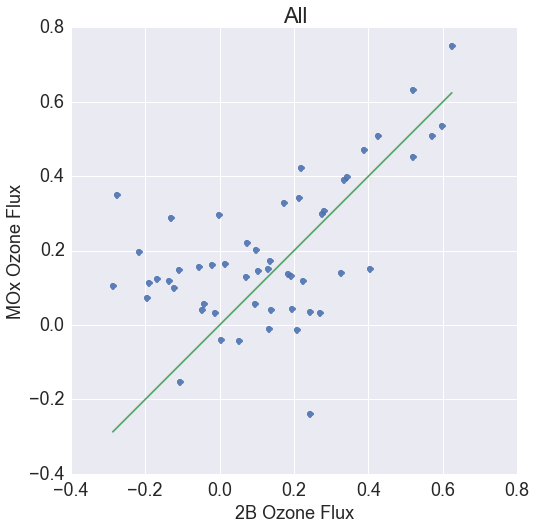

In [565]:
plot_2b_vs_mox(df, 'All')
plt.savefig("all.png")

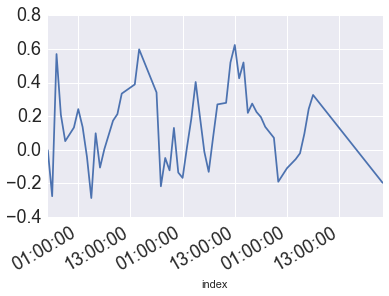

In [566]:
df.flux.plot()

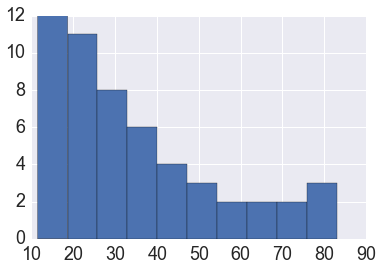

In [567]:
df.c_open.hist()

## Print Average Fluxes measured by both instruments

In [568]:
avg_flux_mox = np.mean(df.mox_flux)
avg_flux_2b = np.mean(df.flux)
print 'MOx flux:', round(avg_flux_mox, 2), "2B flux:", round(avg_flux_2b, 2)

MOx flux: 0.19 2B flux: 0.13


MOx flux: 0.08 2B flux: -0.03


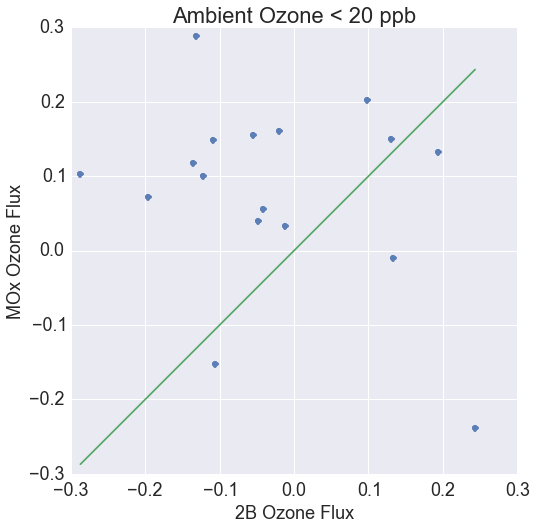

In [569]:
df_under_20 = df[df.c_open < 20]
plot_2b_vs_mox(df_under_20, 'Ambient Ozone < 20 ppb')
avg_flux_mox_under_20 = np.mean(df_under_20.mox_flux)
avg_flux_2b_under_20 = np.mean(df_under_20.flux)
print 'MOx flux:', round(avg_flux_mox_under_20, 2), "2B flux:", round(avg_flux_2b_under_20, 2)
plt.savefig("under_20.png")

MOx flux: 0.25 2B flux: 0.2


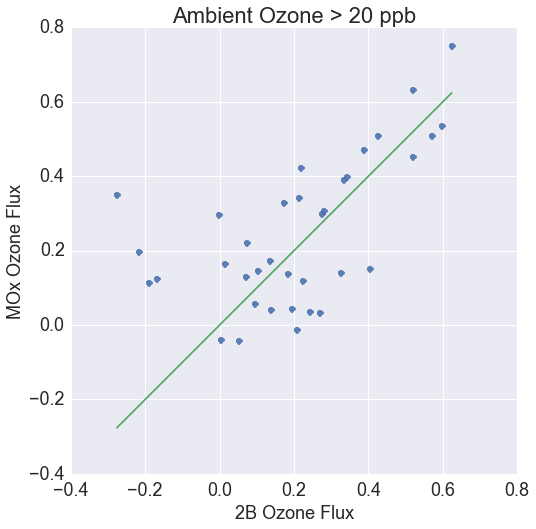

In [570]:
df_20_up = df[df.c_open > 20]
plot_2b_vs_mox(df_20_up, 'Ambient Ozone > 20 ppb')
avg_flux_mox_20_up = np.mean(df_20_up.mox_flux)
avg_flux_2b_20_up = np.mean(df_20_up.flux)
print 'MOx flux:', round(avg_flux_mox_20_up, 2), "2B flux:", round(avg_flux_2b_20_up, 2)

MOx flux: 0.15 2B flux: 0.1


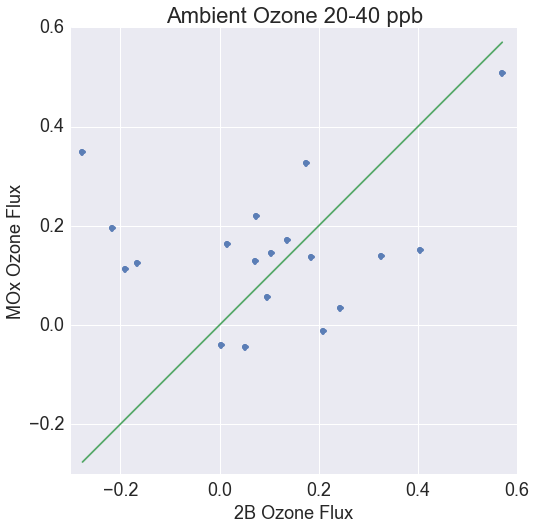

In [571]:
df_20_to_40 = df[(df.c_open < 40) & (df.c_open > 20)]
plot_2b_vs_mox(df_20_to_40, 'Ambient Ozone 20-40 ppb')
avg_flux_mox_20_to_40 = np.mean(df_20_to_40.mox_flux)
avg_flux_2b_20_to_40 = np.mean(df_20_to_40.flux)
print 'MOx flux:', round(avg_flux_mox_20_to_40, 2), "2B flux:", round(avg_flux_2b_20_to_40, 2)

MOx flux: 0.18 2B flux: 0.2


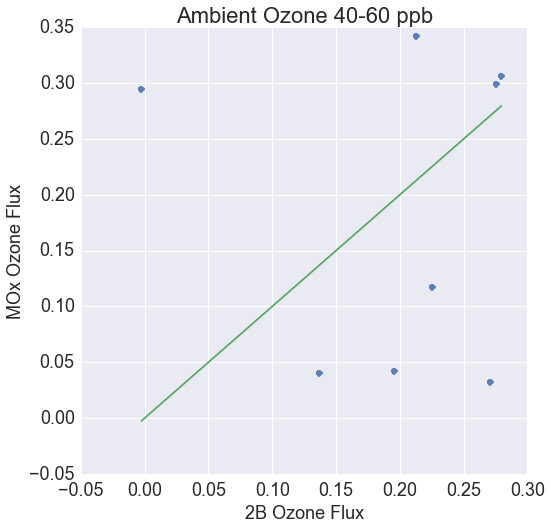

In [572]:
df_40_to_60 = df[(df.c_open < 60) & (df.c_open > 40)]
plot_2b_vs_mox(df_40_to_60, 'Ambient Ozone 40-60 ppb')
avg_flux_mox_40_to_60 = np.mean(df_40_to_60.mox_flux)
avg_flux_2b_40_to_60 = np.mean(df_40_to_60.flux)
print 'MOx flux:', round(avg_flux_mox_40_to_60, 2), "2B flux:", round(avg_flux_2b_40_to_60, 2)

MOx flux: 0.51 2B flux: 0.44


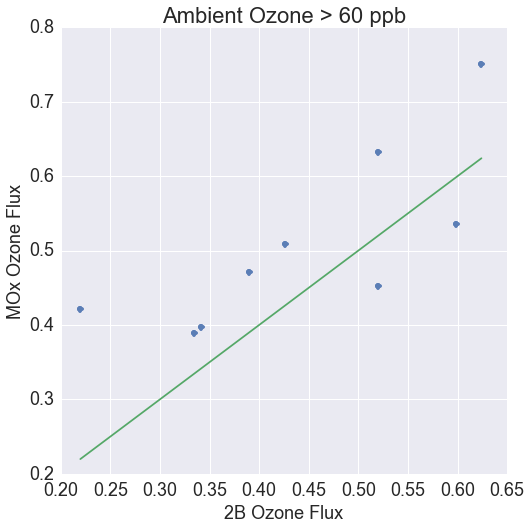

In [573]:
df_60_up = df[df.c_open > 60]
plot_2b_vs_mox(df_60_up, 'Ambient Ozone > 60 ppb')
avg_flux_mox_60_up = np.mean(df_60_up.mox_flux)
avg_flux_2b_60_up = np.mean(df_60_up.flux)
print 'MOx flux:', round(avg_flux_mox_60_up, 2), "2B flux:", round(avg_flux_2b_60_up, 2)

MOx flux: 0.14 2B flux: 0.14


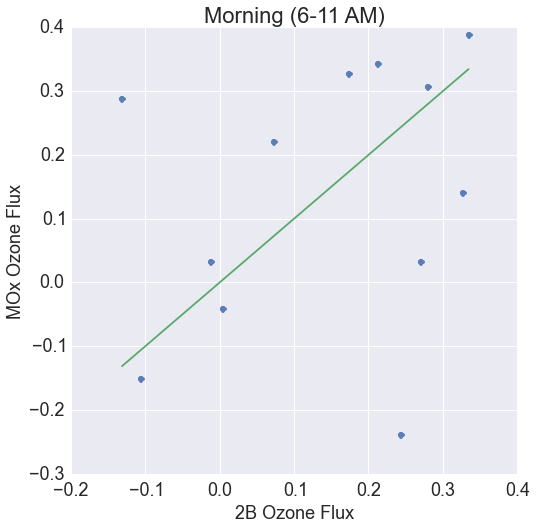

In [574]:
df_morning = df[(df.hour >= 6) & (df.hour < 12)]
plot_2b_vs_mox(df_morning, 'Morning (6-11 AM)')
avg_flux_mox_morning = np.mean(df_morning.mox_flux)
avg_flux_2b_morning = np.mean(df_morning.flux)
print 'MOx flux:', round(avg_flux_mox_morning, 2), "2B flux:", round(avg_flux_2b_morning, 2)

MOx flux: 0.45 2B flux: 0.38


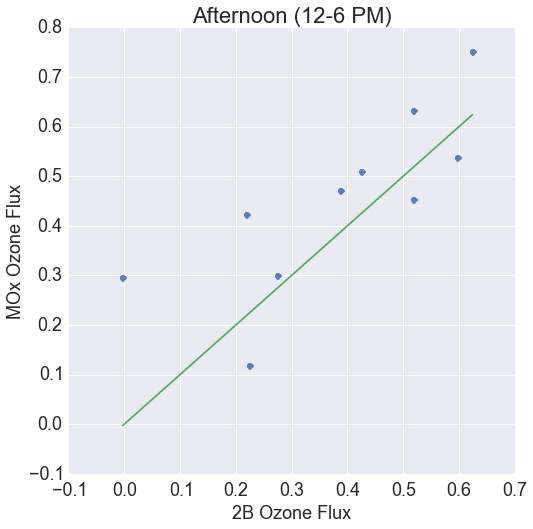

In [575]:
df_afternoon = df[(df.hour > 11) & (df.hour < 19)]
plot_2b_vs_mox(df_afternoon, 'Afternoon (12-6 PM)')
avg_flux_mox_afternoon = np.mean(df_afternoon.mox_flux)
avg_flux_2b_afternoon = np.mean(df_afternoon.flux)
print 'MOx flux:', round(avg_flux_mox_afternoon, 2), "2B flux:", round(avg_flux_2b_afternoon, 2)

MOx flux: 0.15 2B flux: 0.05


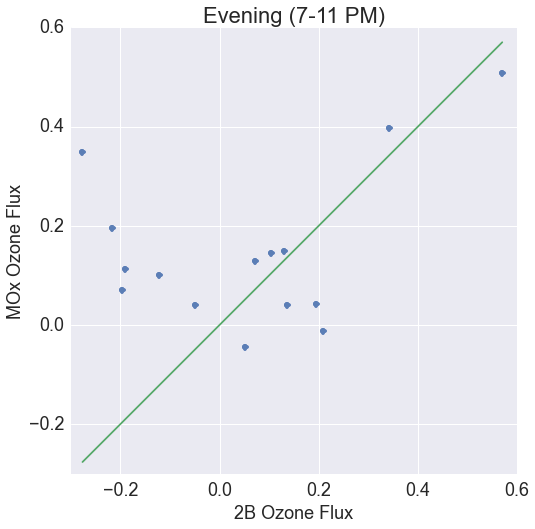

In [576]:
df_evening = df[(df.hour > 18) & (df.hour < 25)]
plot_2b_vs_mox(df_evening, 'Evening (7-11 PM)')
avg_flux_mox_evening = np.mean(df_evening.mox_flux)
avg_flux_2b_evening = np.mean(df_evening.flux)
print 'MOx flux:', round(avg_flux_mox_evening, 2), "2B flux:", round(avg_flux_2b_evening, 2)

MOx flux: 0.12 2B flux: 0.04


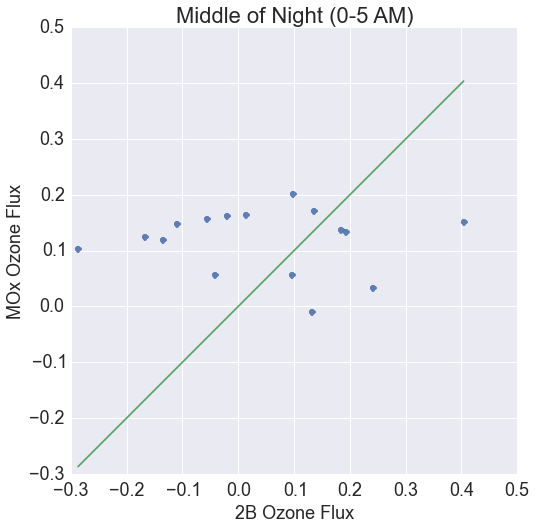

In [577]:
df_night = df[(df.hour >= 0) & (df.hour < 6)]
plot_2b_vs_mox(df_night, 'Middle of Night (0-5 AM)')
avg_flux_mox_night = np.mean(df_night.mox_flux)
avg_flux_2b_night = np.mean(df_night.flux)
print 'MOx flux:', round(avg_flux_mox_night, 2), "2B flux:", round(avg_flux_2b_night, 2)

In [578]:
def plot_mox_and_2b_vs_time(df, xlim):
    plt.figure(facecolor='w', figsize = (15,10))
    a, b, axes, label_size = plot_params()
    df.flux.plot(marker = 'o',linestyle = '--', label = '2B')
    if xlim != None:
        df.mox_flux.plot(marker = 'o',linestyle = '-', xlim = xlim, label = 'MOx')
    else:
        df.mox_flux.plot(marker = 'o',linestyle = '-', label = 'MOx')
#     axes.set_ylim([-10,90])
    plt.legend(fontsize = label_size, loc = "best")
    plt.ylabel('Ozone Flux', size = label_size)
    plt.xlabel('Date', size = label_size)

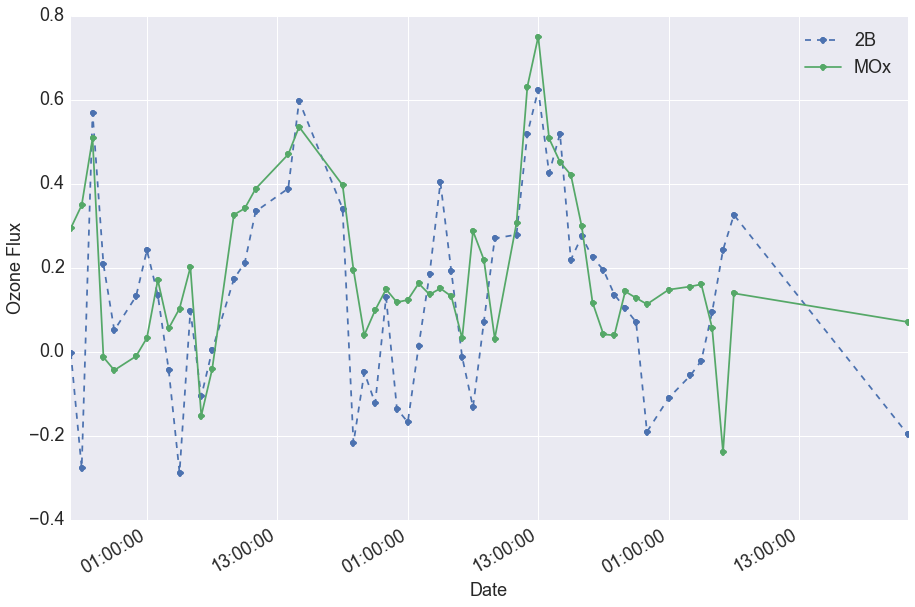

In [579]:
plot_mox_and_2b_vs_time(df, None)

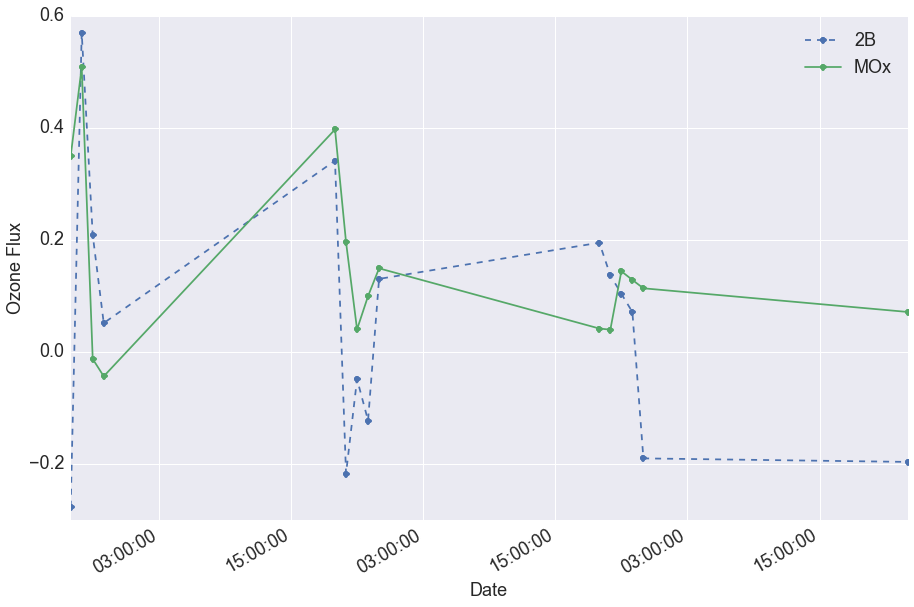

In [580]:
plot_mox_and_2b_vs_time(df_evening, None)